In [1]:
# %pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import pygad

In [2]:
def extract_data(file_path):
    ds = pd.read_json(file_path)
    display(ds)
    preferences = np.array([list(row) for row in ds["preferences"]])
    friendships = np.array([list(row) for row in ds["friendships"]])
    authorship = np.array([list(row) for row in ds["authorship"]])
    capacity = ds["reviewer_capacity"][0]
    min_reviews = ds["min_reviews_per_paper"][0]
    max_reviews = ds["max_reviews_per_paper"][0]
    
    return  preferences, friendships, authorship, capacity, min_reviews, max_reviews


In [3]:
def fitness_function_impl(assignment, preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    # Total Preference Score
    preference_score = np.sum(assignment * preferences)
    max_preference_score = np.sum(np.max(preferences, axis=0))  # Max possible score
    normalized_preference_score = preference_score / max_preference_score

    # Capacity Violation
    capacity_violation = np.sum(np.maximum(0, np.sum(assignment, axis=1) - capacity))

    # Review Violations
    reviews_per_paper = np.sum(assignment, axis=0)
    review_violation = np.sum(np.maximum(0, min_reviews - reviews_per_paper)) + \
                       np.sum(np.maximum(0, reviews_per_paper - max_reviews))

    # Friendship Joint Review Violation
    friendship_violation = 0
    for i in range(len(friendships)):
        for j in range(len(friendships)):
            if friendships[i][j] == 1:
                friendship_violation += np.sum(assignment[i] * assignment[j])

    # Friends Reviewing Each Other's Papers
    friends_authorship_violation = 0
    num_reviewers, num_papers = assignment.shape
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            for friend in range(num_reviewers):
                if friendships[reviewer][friend] == 1 and authorship[friend][paper] == 1:
                    friends_authorship_violation += assignment[reviewer][paper]

    # Authorship Violation
    authorship_violation = np.sum(assignment * authorship)

    # Weights for penalties
    w1, w2, w3, w4, w5 = 2, 3, 2, 3, 4  # Adjusted weights

    # Fitness
    fitness = normalized_preference_score - (w1 * capacity_violation + w2 * review_violation +
                                             w3 * friendship_violation + w4 * friends_authorship_violation +
                                             w5 * authorship_violation)

    # Bias towards non-zero assignments
    bias_reward = 0.01 * np.sum(assignment)  # Small reward for assignments
    fitness += bias_reward

    return fitness


In [4]:
def generate_valid_solution(num_reviewers, num_papers, reviewer_capacity, min_reviews_per_paper, seed=None):
    rng = np.random.default_rng(seed)
    # Initialize the matrix with zeros
    matrix = np.zeros((num_reviewers, num_papers), dtype=int)
    
    # Fill the matrix ensuring no more than K ones per row
    for i in range(num_reviewers):
        ones_to_place = rng.integers(0, reviewer_capacity + 1)  # Randomly decide how many ones to place (up to K)
        columns = rng.choice(num_papers, ones_to_place, replace=False)  # Randomly select columns
        matrix[i, columns] = 1
    
    # Ensure at least S ones in each column
    for j in range(num_papers):
        current_ones = np.sum(matrix[:, j])
        if current_ones < min_reviews_per_paper:
            additional_ones_needed = min_reviews_per_paper - current_ones
            available_rows = [i for i in range(num_reviewers) if matrix[i, j] == 0 and np.sum(matrix[i, :]) < reviewer_capacity]
            if len(available_rows) < additional_ones_needed:
                continue
            
            # Randomly add ones to meet the column constraint
            rows_to_fill = rng.choice(available_rows, additional_ones_needed, replace=False)
            for row in rows_to_fill:
                matrix[row, j] = 1
    
    return matrix


In [5]:
def generate_random_solution(num_reviewers, num_papers, reviewer_capacity):
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    for reviewer in range(num_reviewers):
        # Randomly assign up to 'reviewer_capacity' papers to each reviewer
        papers_to_assign = np.random.choice(num_papers, reviewer_capacity, replace=False)
        solution[reviewer, papers_to_assign] = 1
    return solution

In [6]:
def find_solution1(file_path, parent_selection_type,crossover_type,mutation_type, num_solutions):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        generate_valid_solution(num_reviewers, num_papers, capacity, min_reviews).flatten()
        # generate_random_solution(num_reviewers, num_papers, capacity).flatten()
        for _ in range(num_solutions)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )



    ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=20,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=5
    )


    # Run the genetic algorithm
    ga_instance.run()

    print()
    solution, solution_fitness, _ = ga_instance.best_solution()
    print("Best solution fitness:", solution_fitness)

    # Reshape the solution into the assignment matrix
    best_assignment = solution.reshape((num_reviewers, num_papers))
    print("Best Assignment Matrix:\n", best_assignment)


    ga_instance.plot_fitness()
    

,dataset_id,num_papers,num_reviewers,reviewer_capacity,min_reviews_per_paper,max_reviews_per_paper,preferences,friendships,authorship
0,Easy Dataset 1,5,5,3,3,5,"[3, 2, 1, 5, 3]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
1,Easy Dataset 1,5,5,3,3,5,"[5, 2, 4, 2, 2]","[0, 0, 1, 0, 0]","[0, 1, 0, 0, 0]"
2,Easy Dataset 1,5,5,3,3,5,"[4, 3, 1, 2, 4]","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]"
3,Easy Dataset 1,5,5,3,3,5,"[4, 2, 2, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 0, 0, 1]"
4,Easy Dataset 1,5,5,3,3,5,"[4, 3, 4, 1, 5]","[0, 0, 0, 0, 0]","[0, 0, 1, 1, 0]"


c:\Users\user\miniconda3\envs\intelsys\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



Best solution fitness: -4.713636363636363
Best Assignment Matrix:
 [[1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]]


c:\Users\user\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


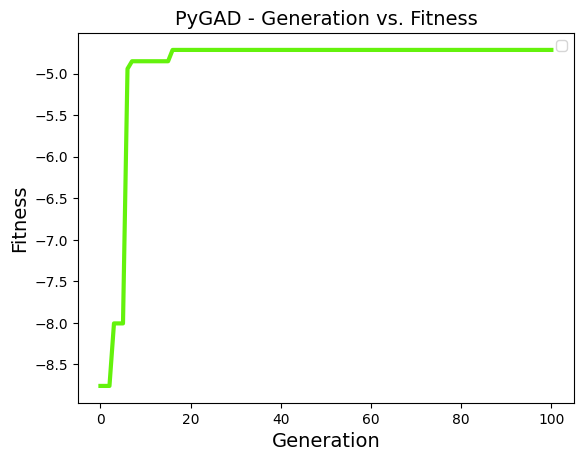

In [8]:
find_solution1("datasets/easy_dataset_1.json", "tournament", "two_points", "random", 50)

In [62]:
def find_solution2(file_path, parent_selection_type,crossover_type,mutation_type, num_solutions, num_parents_mating):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        generate_valid_solution(num_reviewers, num_papers, capacity, min_reviews).flatten()
        # generate_random_solution(num_reviewers, num_papers, capacity).flatten()
        for _ in range(num_solutions + 1)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )

    def custom_crossover(parents, offspring_size, ga_instance):
        
        num_parents, num_genes = parents.shape
        offspring = np.empty(offspring_size, dtype=parents.dtype)
        
        child_index = 0  # To keep track of the child being created
        
        while child_index < offspring_size[0]:
            # Select two parents
            parent1_idx = np.random.randint(0, num_parents)
            parent2_idx = np.random.randint(0, num_parents)
            
            while parent2_idx == parent1_idx:
                parent2_idx = np.random.randint(0, num_parents)
            
            # Reshape parents into matrices
            parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
            parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))
            
            # Initialize child matrices
            child1_matrix = np.empty_like(parent1_matrix)
            child2_matrix = np.empty_like(parent2_matrix)
            
            # Row-wise crossover for two children
            for row in range(num_reviewers):
                if np.random.rand() < 0.5:
                    child1_matrix[row] = parent1_matrix[row]
                    child2_matrix[row] = parent2_matrix[row]
                else:
                    child1_matrix[row] = parent2_matrix[row]
                    child2_matrix[row] = parent1_matrix[row]
            
            # Flatten child matrices into 1D and store in offspring
            offspring[child_index] = child1_matrix.flatten()
            child_index += 1
            
            if child_index < offspring_size[0]:
                offspring[child_index] = child2_matrix.flatten()
                child_index += 1
        
        return offspring
    
    def custom_mutation(offspring, ga_instance):
        num_children, num_genes = offspring.shape
        mutation_percent_genes = ga_instance.mutation_percent_genes

        # Calculate the number of genes to mutate per child
        num_mutations = max(1, int((mutation_percent_genes / 100) * num_genes))

        for child_index in range(num_children):
            # Randomly select `num_mutations` genes to mutate for the current child
            mutation_indices = np.random.choice(num_genes, size=num_mutations, replace=False)

            # Flip the value of the selected genes
            for gene_index in mutation_indices:
                offspring[child_index, gene_index] = 1 - offspring[child_index, gene_index]

        return offspring
   


    ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=custom_crossover,
    mutation_type=custom_mutation,           # Custom mutation
    mutation_percent_genes=2
    )


    # Run the genetic algorithm
    ga_instance.run()

    print()
    solution, solution_fitness, _ = ga_instance.best_solution()
    print("Best solution fitness:", solution_fitness)

    # Reshape the solution into the assignment matrix
    best_assignment = solution.reshape((num_reviewers, num_papers))
    print("Best Assignment Matrix:\n", best_assignment)

    

    ga_instance.plot_fitness()
    

,dataset_id,num_papers,num_reviewers,reviewer_capacity,min_reviews_per_paper,max_reviews_per_paper,preferences,friendships,authorship
0,Medium Dataset 1,10,7,5,3,5,"[4, 5, 5, 1, 2, 2, 2, 1, 5, 4]","[0, 1, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,Medium Dataset 1,10,7,5,3,5,"[2, 5, 5, 5, 1, 3, 2, 4, 5, 4]","[1, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,Medium Dataset 1,10,7,5,3,5,"[2, 1, 4, 2, 5, 1, 3, 3, 5, 1]","[1, 0, 0, 1, 1, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,Medium Dataset 1,10,7,5,3,5,"[2, 4, 3, 1, 5, 2, 3, 2, 1, 1]","[1, 0, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,Medium Dataset 1,10,7,5,3,5,"[2, 1, 4, 3, 3, 1, 3, 3, 5, 3]","[0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,Medium Dataset 1,10,7,5,3,5,"[0, 2, 4, 2, 3, 3, 5, 5, 5, 4]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
6,Medium Dataset 1,10,7,5,3,5,"[5, 1, 3, 2, 3, 0, 1, 0, 5, 4]","[0, 0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 1, 0, 1, 0, 0]"


c:\Users\user\miniconda3\envs\intelsys\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



Best solution fitness: -9.773829787234042
Best Assignment Matrix:
 [[0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1. 1.]]


c:\Users\user\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


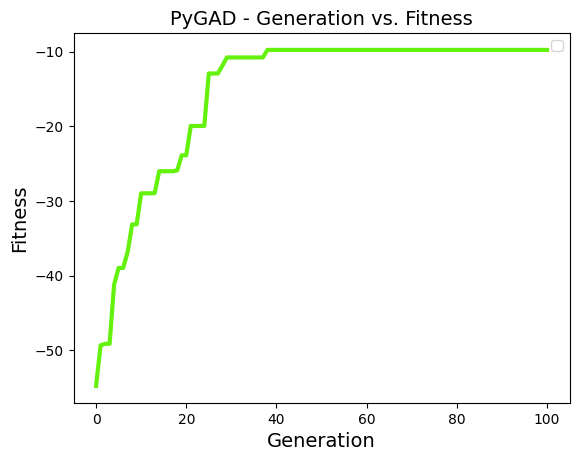

In [66]:
find_solution2("datasets/medium_dataset_1.json", "tournament", "two_points", "random", 150, 60)

In [67]:
def find_solution3(file_path, parent_selection_type,crossover_type,mutation_type, num_solutions, num_parents_mating):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        generate_valid_solution(num_reviewers, num_papers, capacity, min_reviews).flatten()
        # generate_random_solution(num_reviewers, num_papers, capacity).flatten()
        for _ in range(num_solutions + 1)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )

    def custom_crossover(parents, offspring_size, ga_instance):
        
        num_parents, num_genes = parents.shape
        offspring = np.empty(offspring_size, dtype=parents.dtype)
        
        child_index = 0  # To keep track of the child being created
        
        while child_index < offspring_size[0]:
            # Select two parents
            parent1_idx = np.random.randint(0, num_parents)
            parent2_idx = np.random.randint(0, num_parents)
            
            while parent2_idx == parent1_idx:
                parent2_idx = np.random.randint(0, num_parents)
            
            # Reshape parents into matrices
            parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
            parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))
            
            # Initialize child matrices
            child1_matrix = np.empty_like(parent1_matrix)
            child2_matrix = np.empty_like(parent2_matrix)
            
            # Row-wise crossover for two children
            for row in range(num_reviewers):
                if np.random.rand() < 0.5:
                    child1_matrix[row] = parent1_matrix[row]
                    child2_matrix[row] = parent2_matrix[row]
                else:
                    child1_matrix[row] = parent2_matrix[row]
                    child2_matrix[row] = parent1_matrix[row]
            
            # Flatten child matrices into 1D and store in offspring
            offspring[child_index] = child1_matrix.flatten()
            child_index += 1
            
            if child_index < offspring_size[0]:
                offspring[child_index] = child2_matrix.flatten()
                child_index += 1
        
        return offspring
    
    def custom_mutation(offspring, ga_instance):
        num_children, num_genes = offspring.shape
        mutation_percent_genes = ga_instance.mutation_percent_genes

        # Calculate the number of genes to mutate per child
        num_mutations = max(1, int((mutation_percent_genes / 100) * num_genes))

        for child_index in range(num_children):
            # Randomly select `num_mutations` genes to mutate for the current child
            mutation_indices = np.random.choice(num_genes, size=num_mutations, replace=False)

            # Flip the value of the selected genes
            for gene_index in mutation_indices:
                offspring[child_index, gene_index] = 1 - offspring[child_index, gene_index]

        return offspring
   


    ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=custom_crossover,
    mutation_type=custom_mutation,           # Custom mutation
    mutation_percent_genes=2
    )


    # Run the genetic algorithm
    ga_instance.run()

    print()
    solution, solution_fitness, _ = ga_instance.best_solution()
    print("Best solution fitness:", solution_fitness)

    # Reshape the solution into the assignment matrix
    best_assignment = solution.reshape((num_reviewers, num_papers))
    print("Best Assignment Matrix:\n", best_assignment)

    

    ga_instance.plot_fitness()
    